In [3]:
import xarray as xr 
import numpy as np
import matplotlib.pyplot as plt

In [4]:
sf = xr.open_dataset("surface_fluxes.nc")
col = xr.open_dataset("~/Downloads/column.nc")
geo = xr.open_dataset("geolocation.nc")
sf

<xarray.Dataset> Size: 86MB
Dimensions:     (valid_time: 120, latitude: 141, longitude: 181)
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 960B 2008-07-01 ... 2008-07-05T23...
  * latitude    (latitude) float64 1kB 35.0 34.75 34.5 34.25 ... 0.5 0.25 0.0
  * longitude   (longitude) float64 1kB -155.0 -154.8 -154.5 ... -110.2 -110.0
    expver      (valid_time) <U4 2kB ...
Data variables:
    t2m         (valid_time, latitude, longitude) float32 12MB ...
    sst         (valid_time, latitude, longitude) float32 12MB ...
    tp          (valid_time, latitude, longitude) float32 12MB ...
    skt         (valid_time, latitude, longitude) float32 12MB ...
    slhf        (valid_time, latitude, longitude) float32 12MB ...
    sshf        (valid_time, latitude, longitude) float32 12MB ...
    tisr        (valid_time, latitude, longitude) float32 12MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-10-04T22:15 GRIB to CDM+CF via cfgrib-0.9.1...

In [266]:
minsite = 2
maxsite = 23
lats = geo.where((geo["site"] <=maxsite) & (geo["site"] >= minsite) & (geo["site"] != 16), drop = True).lat
lons = geo.where((geo["site"] <=maxsite) & (geo["site"] >= minsite) & (geo["site"] != 16), drop = True).lon
sites = geo.where((geo["site"] <=maxsite) & (geo["site"] >= minsite) & (geo["site"] != 16), drop = True).site

In [273]:
sites.where(sites.site <16, drop = True).lon - 360

<xarray.DataArray 'lon' (site: 14)> Size: 56B
array([ -72.5     ,  -75.      ,  -77.5     ,  -80.      ,  -82.5     ,
        -85.      ,  -90.      ,  -95.      , -100.      , -105.      ,
       -110.      , -115.      , -120.      , -125.100006], dtype=float32)
Coordinates:
  * site     (site) int32 56B 2 3 4 5 6 7 8 9 10 11 12 13 14 15
    lat      (site) float32 56B -20.0 -20.0 -20.0 -20.0 ... -11.0 -9.5 -8.0
    lon      (site) float32 56B 287.5 285.0 282.5 280.0 ... 245.0 240.0 234.9

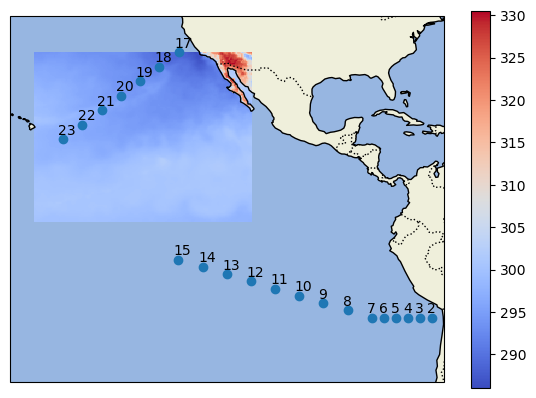

In [85]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

fig = plt.figure(figsize=(7, 7))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.OCEAN)

data = ax.pcolormesh(sf.longitude - 360, sf.latitude,  sf["skt"][0], transform=ccrs.PlateCarree(), cmap='coolwarm')

# colorbar
cbar = plt.colorbar(data, orientation='vertical', shrink=.7)

plt.scatter(lons, lats)
for i, txt in enumerate([str(elt) for elt in sites.values]):
    plt.annotate(txt, (lons[i]-1, lats[i]+1))

ax.set_extent([-160, -70, -25, 33])



In [261]:
def get_tendencies(lon, lat, col):
    west = col.where((col.latitude == lat) & (col.longitude == lon - .25), drop = True).isel(latitude=0, longitude=0).squeeze()
    east = col.where((col.latitude == lat) & (col.longitude == lon + .25), drop = True).isel(latitude=0, longitude=0).squeeze()
    north = col.where((col.latitude == lat + .25) & (col.longitude == lon), drop = True).isel(latitude=0, longitude=0).squeeze()
    south = col.where((col.latitude == lat - .25) & (col.longitude == lon), drop = True).isel(latitude=0, longitude=0).squeeze()
    center = col.where((col.latitude == lat) & (col.longitude == lon), drop = True).isel(latitude=0, longitude=0).squeeze()
    
    # convert to radians for gradient calculation 
    rearth = 6378e3
    lat = np.deg2rad(lat)
    lon = np.deg2rad(lon - 360)
    coslat = np.cos(lat)
    dx = 2 * np.pi * rearth * coslat / 360 # per degree longitude
    dy = 2 * np.pi * rearth / 360 # per degree latitude

    # compute advective tendencies
    # Temperature
    tntha = center.u * (west.t - 2 * center.t + east.t) / (2 * dx / 4) + center.v * (south.t - 2 * center.t + north.t) / (2 * dy / 4)
    # specific humidity
    tnhusha = center.u * (west.q - 2 * center.q + east.q) / (2 * dx / 4) + center.v * (south.q - 2 * center.q + north.q) / (2 * dy / 4)

    return tntha, tnhusha

#get_tendencies(lon, lat, col)[0]

def calc_vertical_tendencies(center, var, vertvar = "wa"):
    """
    Calculate the temperature and specific humidity tendencies as a function of levels
    using vertical advection.
    """
    tntva_trend = []
    
    # Loop through each pressure level
    num_levels = center[vertvar].shape[1]  # Number of vertical levels

    for i in range(num_levels):
        if i == 0:  # Bottom level (forward difference)
            tntva = center[vertvar][:, i] * (center[var][:, i+1] - center[var][:, i]) / (center.z[:, i+1] - center.z[:, i])
        
        elif i == num_levels - 1:  # Top level (backward difference)
            tntva = center[vertvar][:, i] * (center[var][:, i] - center[var][:, i-1]) / (center.z[:, i] - center.z[:, i-1])
        
        else:  # Middle levels (centered difference)
            tntva = center[vertvar][:, i] * (center[var][:, i+1] - 2 * center[var][:, i] +  center[var][:, i-1]) / ((center.z[:, i+1] - center.z[:, i-1]))

        tntva = tntva.assign_coords(pressure_level=center.pressure_level[i])

        # Append the result to the trend list
        tntva_trend.append(tntva)
    
    # Convert the trend list to an xarray object, correctly indexed by pressure levels
    tntva_trend = xr.concat(tntva_trend, dim="pressure_level")
    tntva_trend = tntva_trend.assign_coords(pressure_level=center.pressure_level)

    # transpose so time is the first dimension
    tntva_trend = tntva_trend.transpose("valid_time", "pressure_level")

    return tntva_trend

def get_forcing_data(group, col = col, sf = sf, geo = geo):
    loc = geo.where(geo["site"] == group, drop = True)

    sitesf = sf.where((sf.latitude == loc.lat.values[0]) & (sf.longitude == loc.lon.values[0] - 360), drop = True)
    sitecol = col.where((col.latitude == loc.lat.values[0]) & (col.longitude == loc.lon.values[0] - 360), drop = True)

    ##### get column data #####
    # compute temperature
    R_d = 287.05  # Specific gas constant for dry air (J/(kg·K))
    g = 9.81  # Gravitational acceleration (m/s²)
    pressure = sitecol.pressure_level * 100  # Convert to Pa
    pressure_broadcasted = pressure.broadcast_like(col.t)
    # Compute air density using the ideal gas law: rho = P / (R_d * T)
    rho = pressure_broadcasted / (R_d * col.t)
    sitecol["rho"] = rho


    ##### get surface data #####
    coszen = xr.open_dataset("/Users/julianschmitt/Downloads/HadGEM2-A_amip.2004-2008.07.nc", group = f"site{group}").coszen
    # rescale TOA incident radiation to w/m2 by dividing by the time step of ERA5 (1 hour)
    sitesf["tisr"] = sitesf["tisr"] / 3600

    #### Combine data ####
    sitecol["coszen"] = coszen

    sitedata = xr.merge([sitecol[["z", "t", "rho", "u", "v", "w", "q", "coszen"]], sitesf[["slhf", "sshf", "tisr", "skt"]]])

    sitedata = sitedata.rename({"t": "ta", "u": "ua", "v": "va", "w": "wa", "q": "hus", "slhf": "hfls", "sshf": "hfss", "skt": "ts", "tisr": "rsdt"})

    # remove latitude/longitude dependence
    sitedata = sitedata.isel(latitude=0, longitude=0).squeeze()

    # calculate tendency terms
    sitedata["wap"] = sitedata["wa"] * sitedata["rho"]
    # temperature vertical tendency due to vertical advection
    sitedata["tntva"] = calc_vertical_tendencies(sitedata, "ta")
    # specific humidity vertical tendency due to vertical advection
    sitedata["tnhusva"] = calc_vertical_tendencies(sitedata, "hus")


    # compute horizontal tendencies
    tntha, tnhusha = get_tendencies(loc.lon.values[0] - 360, loc.lat.values[0], col)

    sitedata["tntha"] = tntha
    sitedata["tnhusha"] = tnhusha

    # approximate geopotential 
    sitedata["zg"] = sitedata["z"] / 9.81
    
    return sitedata
t = get_forcing_data(18)

In [262]:
# Path to the NetCDF file
output_file = 'era5_forcing_v2.nc'

# Loop over site IDs (from 2 to 23)
for site_id in range(18, 24):
    # Get the dataset for the current site
    ds = get_forcing_data(site_id)
    
    # Save the dataset to the NetCDF file as a group named "siteXX" (e.g., "site2", "site3", ...)
    ds.to_netcdf(output_file, mode='a', group=f'site{site_id}')

In [264]:
geo.sel((site))

<xarray.Dataset> Size: 2kB
Dimensions:                        (site: 119)
Coordinates:
  * site                           (site) int32 476B 1 2 3 4 ... 116 117 118 119
    lat                            (site) float32 476B ...
    lon                            (site) float32 476B ...
Data variables:
    __xarray_dataarray_variable__  (site) float32 476B ...
Attributes:
    __xarray_dataarray_name__:  lon

In [258]:
t.tntva.transpose("valid_time", "pressure_level")

<xarray.DataArray 'tntva' (valid_time: 120, pressure_level: 37)> Size: 18kB
array([[ 1.13214583e-05,  3.28581041e-06,  6.32270712e-07, ...,
        -4.76388540e-10, -9.12637930e-08, -8.15055188e-08],
       [ 2.09156242e-05, -2.67250380e-06, -1.36519105e-07, ...,
         8.09162515e-09, -6.07112298e-08, -4.79207785e-08],
       [-2.00305458e-05,  9.94249058e-06,  1.78424784e-06, ...,
         2.76138117e-08,  2.80262231e-08, -1.01943748e-07],
       ...,
       [-6.92377216e-06, -2.82568480e-09,  1.63513721e-06, ...,
         9.36802103e-09, -1.26465274e-08,  1.04942636e-07],
       [-4.72262309e-06,  8.60594184e-07, -6.18995159e-07, ...,
         9.04208486e-10, -4.03917468e-08,  9.70789387e-08],
       [-4.90594321e-05,  1.81263590e-06,  1.09453358e-05, ...,
        -1.10742207e-07,  1.39435585e-07,  1.13329662e-07]], dtype=float32)
Coordinates:
  * valid_time      (valid_time) datetime64[ns] 960B 2008-07-01 ... 2008-07-0...
  * pressure_level  (pressure_level) float64 296B 1e+03 975.0 950.0 ... 2.0 1.0
    latitude        float64 8B 32.0
    longitude       float64 8B -129.0
    number          int64 8B 0
    expver          (valid_time) <U4 2kB '0001' '0001' '0001' ... '0001' '0001'
    lon             float32 4B ...
    lat             float32 4B ...
    site            int32 4B ...

In [248]:
t.tntha.values.shape

(120, 37)

In [235]:
hadgem.tntha

<xarray.DataArray 'tntha' (time: 600, lev: 38)> Size: 91kB
array([[-1.632074e-05, -1.798655e-05, -1.829345e-05, ..., -6.050564e-05,
         7.917081e-05,  1.042462e-05],
       [-9.230890e-06, -9.422567e-06, -9.685845e-06, ..., -1.547076e-06,
        -8.380666e-06, -1.781699e-05],
       [-1.156452e-05, -1.216406e-05, -1.237467e-05, ...,  2.907143e-05,
        -4.025018e-05, -4.217114e-06],
       ...,
       [-1.447636e-05, -1.656419e-05, -1.706068e-05, ...,  2.163953e-05,
        -7.171408e-05, -2.734287e-05],
       [-1.665831e-05, -1.913429e-05, -1.919993e-05, ...,  5.117800e-05,
        -4.376223e-05, -1.263740e-05],
       [-2.447590e-05, -2.852176e-05, -2.935004e-05, ..., -1.974220e-05,
        -2.197325e-06,  3.575737e-05]], dtype=float32)
Coordinates:
    lon      float32 4B ...
    lat      float32 4B ...
    site     int32 4B ...
  * lev      (lev) float64 304B 20.0 80.0 180.0 ... 3.291e+04 3.925e+04
  * time     (time) object 5kB 2004-07-01 00:00:00 ... 2008-07-30 18:00:00

In [116]:
rearth = 6378e3
lat = np.deg2rad(t.latitude)
lon = np.deg2rad(t.longitude)
coslat = np.cos(lat)
dx = 2 * np.pi * rearth * coslat / 360 # per degree longitude
dy = 2 * np.pi * rearth / 360 # per degree latitude

tloc = geo.where(geo["site"] == 23, drop = True)
lat = tloc.lat.values[0]
lon = tloc.lon.values[0] - 360
west = col.where((col.latitude == lat) & (col.longitude == lon - .25), drop = True).isel(latitude=0, longitude=0).squeeze()
east = col.where((col.latitude == lat) & (col.longitude == lon + .25), drop = True).isel(latitude=0, longitude=0).squeeze()
north = col.where((col.latitude == lat + .25) & (col.longitude == lon), drop = True).isel(latitude=0, longitude=0).squeeze()
south = col.where((col.latitude == lat - .25) & (col.longitude == lon), drop = True).isel(latitude=0, longitude=0).squeeze()
center = col.where((col.latitude == lat) & (col.longitude == lon), drop = True).isel(latitude=0, longitude=0).squeeze()

tntha = center.u * (west.t - 2 * center.t + east.t) / (2 * dx / 4) + center.v * (south.t - 2 * center.t + north.t) / (2 * dy / 4)

# repeat for q 
tnhusha = center.u * (west.q - 2 * center.q + east.q) / (2 * dx / 4) + center.v * (south.q - 2 * center.q + north.q) / (2 * dy / 4)

# compute the verical advection
tntva_trend = calc_vertical_tendencies(center, "t")

<xarray.DataArray 'z' (valid_time: 120, pressure_level: 37)> Size: 18kB
array([[  1331.6484,   3483.1177,   5674.494 , ..., 388714.    ,
        418602.8   , 470359.3   ],
       [  1278.4648,   3431.1123,   5623.478 , ..., 388647.12  ,
        418575.38  , 470422.5   ],
       [  1261.1094,   3414.6917,   5608.047 , ..., 388815.06  ,
        418784.2   , 470680.5   ],
       ...,
       [  1412.375 ,   3568.8599,   5765.5547, ..., 388575.88  ,
        418358.62  , 470618.06  ],
       [  1383.9883,   3541.3862,   5738.8984, ..., 388694.56  ,
        418277.62  , 470671.12  ],
       [  1347.4336,   3505.8337,   5704.082 , ..., 388663.    ,
        418220.12  , 470703.75  ]], dtype=float32)
Coordinates:
    number          int64 8B 0
  * valid_time      (valid_time) datetime64[ns] 960B 2008-07-01 ... 2008-07-0...
  * pressure_level  (pressure_level) float64 296B 1e+03 975.0 950.0 ... 2.0 1.0
    latitude        float64 8B 17.0
    longitude       float64 8B -149.0
    expver          (valid_time) <U4 2kB ...
Attributes: (12/31)
    GRIB_paramId:                             129
    GRIB_dataType:                            an
    GRIB_numberOfPoints:                      25521
    GRIB_typeOfLevel:                         isobaricInhPa
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_shortName:                           z
    GRIB_totalNumber:                         0
    GRIB_units:                               m**2 s**-2
    long_name:                                Geopotential
    units:                                    m**2 s**-2
    standard_name:                            geopotential

In [183]:

def calc_vertical_tendencies(center, var):
    """
    Calculate the temperature and specific humidity tendencies as a function of levels
    using vertical advection.
    """
    tntva_trend = []
    
    # Loop through each pressure level
    num_levels = center.w.shape[1]  # Number of vertical levels

    for i in range(num_levels):
        if i == 0:  # Bottom level (forward difference)
            tntva = center.w[:, i] * (center[var][:, i+1] - center[var][:, i]) / (center.z[:, i+1] - center.z[:, i])
        
        elif i == num_levels - 1:  # Top level (backward difference)
            tntva = center.w[:, i] * (center[var][:, i] - center[var][:, i-1]) / (center.z[:, i] - center.z[:, i-1])
        
        else:  # Middle levels (centered difference)
            tntva = center.w[:, i] * (center[var][:, i+1] - 2 * center[var][:, i] +  center[var][:, i-1]) / ((center.z[:, i+1] - center.z[:, i-1]))

        tntva = tntva.assign_coords(pressure_level=center.pressure_level[i])

        # Append the result to the trend list
        tntva_trend.append(tntva)
    
    # Convert the trend list to an xarray object, correctly indexed by pressure levels
    tntva_trend = xr.concat(tntva_trend, dim="pressure_level")
    tntva_trend = tntva_trend.assign_coords(pressure_level=center.pressure_level)

    return tntva_trend

tntva_trend = calc_vertical_tendencies(center, "t")

In [219]:
tntva_trend[0, :]

<xarray.DataArray (valid_time: 120)> Size: 480B
array([-2.75144557e-05,  1.35491928e-05,  3.14463650e-05,  8.59203192e-06,
       -1.60025975e-05, -1.38804216e-05, -2.29897614e-05, -2.50588128e-05,
       -7.53809309e-06,  1.22636975e-05,  1.21097155e-05,  1.92687321e-06,
        1.04373985e-05, -1.36060899e-05, -1.02260447e-05,  4.32611751e-06,
       -2.85788446e-05, -3.64474145e-05, -1.79881627e-05, -3.58524703e-05,
        7.15926717e-06, -3.07732830e-06,  1.03530592e-05,  2.64056198e-05,
       -1.71744307e-06,  7.48241746e-06,  1.75734731e-05, -1.90777937e-05,
       -7.05608454e-06, -1.76476278e-05, -1.00879588e-05, -1.67713351e-05,
       -1.33250060e-05, -9.56202894e-06,  2.15840973e-05,  2.91410902e-06,
        7.79607126e-06,  4.27205032e-06, -4.22092489e-06,  8.11095742e-06,
       -7.18998535e-06, -2.17289671e-05, -3.07520850e-06, -9.77857144e-06,
        1.68057941e-05,  3.33504722e-05,  3.41838677e-05,  3.56484015e-05,
        5.41603185e-05,  4.73543550e-05,  3.70824891e-05,  1.12800390e-05,
        1.92404259e-05, -8.34853381e-06, -7.46132673e-06, -1.74788911e-05,
       -7.03457727e-06,  6.51279106e-06,  1.12591115e-05,  5.38481436e-06,
       -9.22038362e-06,  4.06920799e-06, -1.81141306e-08, -7.35314779e-06,
       -1.78748505e-05, -3.06587317e-05, -1.41545406e-05, -2.66130137e-05,
       -2.10347407e-05, -2.55157029e-05, -7.22851337e-06,  2.91687365e-06,
        1.44106407e-05,  5.81608356e-06,  1.56801852e-05, -2.20925249e-05,
       -7.11406028e-06, -3.42401945e-05, -2.64726696e-05, -3.49330803e-05,
       -1.21100011e-05,  1.60531931e-06, -8.85945610e-07,  2.66165735e-05,
        1.73640419e-05,  1.57283066e-05,  4.85436476e-06, -1.08868680e-05,
       -3.56126407e-06, -3.72720388e-06,  3.32267564e-06,  1.95030025e-05,
        2.31874255e-05,  1.84915916e-05, -5.28589226e-06,  3.44304244e-05,
        2.87175681e-05,  1.72959117e-05,  3.57585377e-05,  1.62632247e-07,
        7.90622562e-06, -2.19734120e-05, -3.53662581e-05, -1.84957553e-05,
        3.13615192e-06,  2.37965633e-05,  1.88316735e-05,  9.90199078e-06,
        2.07190569e-05, -2.03444756e-06, -2.71138306e-05, -5.63927279e-06,
       -3.87694818e-05, -1.77408001e-05, -1.95128541e-05, -3.14054705e-06,
       -3.66543486e-06, -4.97243173e-06,  1.33256472e-05, -1.39520507e-05],
      dtype=float32)
Coordinates:
    number          int64 8B 0
  * valid_time      (valid_time) datetime64[ns] 960B 2008-07-01 ... 2008-07-0...
    latitude        float64 8B 17.0
    longitude       float64 8B -149.0
    expver          (valid_time) <U4 2kB '0001' '0001' '0001' ... '0001' '0001'
    pressure_level  float64 8B 1e+03

In [218]:
hadgem.tntva[:, -4]

<xarray.DataArray 'tntva' (time: 600)> Size: 2kB
array([ 1.901959e-05,  1.674047e-06, -2.395650e-06, ..., -1.414173e-06,
        1.506024e-06,  2.877714e-06], dtype=float32)
Coordinates:
    lon      float32 4B ...
    lat      float32 4B ...
    site     int32 4B ...
    lev      float64 8B 2.658e+04
  * time     (time) object 5kB 2004-07-01 00:00:00 ... 2008-07-30 18:00:00

In [98]:
# functionalize the tendency calculations 
def get_tendencies(lon, lat, col):
    west = col.where((col.latitude == lat) & (col.longitude == lon - .25), drop = True).isel(latitude=0, longitude=0).squeeze()
    east = col.where((col.latitude == lat) & (col.longitude == lon + .25), drop = True).isel(latitude=0, longitude=0).squeeze()
    north = col.where((col.latitude == lat + .25) & (col.longitude == lon), drop = True).isel(latitude=0, longitude=0).squeeze()
    south = col.where((col.latitude == lat - .25) & (col.longitude == lon), drop = True).isel(latitude=0, longitude=0).squeeze()
    center = col.where((col.latitude == lat) & (col.longitude == lon), drop = True).isel(latitude=0, longitude=0).squeeze()
    
    # convert to radians for gradient calculation 
    rearth = 6378e3
    lat = np.deg2rad(lat)
    lon = np.deg2rad(lon - 360)
    coslat = np.cos(lat)
    dx = 2 * np.pi * rearth * coslat / 360 # per degree longitude
    dy = 2 * np.pi * rearth / 360 # per degree latitude

    # compute advective tendencies
    # Temperature
    tntha = center.u * (west.t - 2 * center.t + east.t) / (2 * dx / 4) + center.v * (south.t - 2 * center.t + north.t) / (2 * dy / 4)
    # specific humidity
    tnhusha = center.u * (west.q - 2 * center.q + east.q) / (2 * dx / 4) + center.v * (south.q - 2 * center.q + north.q) / (2 * dy / 4)

    return tntha, tnhusha

get_tendencies(lon, lat, col)[0]


<xarray.DataArray (valid_time: 120, pressure_level: 37)> Size: 18kB
array([[-4.4340331e-06, -7.0144038e-06, -9.2385226e-06, ...,
         2.1226107e-05, -8.9030027e-07, -3.5042158e-05],
       [-3.3164058e-06, -5.3600434e-06, -8.4528019e-06, ...,
         1.9916457e-05, -1.9385978e-05,  4.2046308e-06],
       [ 6.8233788e-08, -2.1901976e-06, -6.7764850e-06, ...,
         1.1896117e-05, -1.4619983e-05,  3.8080692e-05],
       ...,
       [ 4.3163891e-07, -2.7534777e-06, -2.4839032e-06, ...,
         1.4321859e-06,  1.1797360e-05, -9.0727990e-06],
       [ 6.1274943e-07, -3.0444971e-06, -8.8684010e-06, ...,
         2.3764978e-06,  2.0278125e-05, -4.7086969e-06],
       [-2.6430936e-07, -5.7508255e-06, -1.3844690e-05, ...,
        -3.7713045e-05,  1.0529745e-05,  4.9639984e-06]], dtype=float32)
Coordinates:
    number          int64 8B 0
  * valid_time      (valid_time) datetime64[ns] 960B 2008-07-01 ... 2008-07-0...
  * pressure_level  (pressure_level) float64 296B 1e+03 975.0 950.0 ... 2.0 1.0
    latitude        float64 8B 17.0
    expver          (valid_time) <U4 2kB '0001' '0001' '0001' ... '0001' '0001'
    longitude       float64 8B -149.0

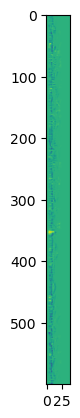

In [104]:
plt.imshow(hadgem.tnhusva.values)

In [90]:
tntha

<xarray.DataArray (valid_time: 120, pressure_level: 37)> Size: 36kB
array([[-4.43403323e-06, -7.01440341e-06, -9.23852244e-06, ...,
         2.12261060e-05, -8.90300442e-07, -3.50421560e-05],
       [-3.31640580e-06, -5.36004365e-06, -8.45280185e-06, ...,
         1.99164564e-05, -1.93859772e-05,  4.20463114e-06],
       [ 6.82338028e-08, -2.19019775e-06, -6.77648490e-06, ...,
         1.18961167e-05, -1.46199829e-05,  3.80806908e-05],
       ...,
       [ 4.31638788e-07, -2.75347766e-06, -2.48390316e-06, ...,
         1.43218614e-06,  1.17973599e-05, -9.07279893e-06],
       [ 6.12749492e-07, -3.04449714e-06, -8.86840075e-06, ...,
         2.37649783e-06,  2.02781243e-05, -4.70869694e-06],
       [-2.64309361e-07, -5.75082534e-06, -1.38446907e-05, ...,
        -3.77130453e-05,  1.05297455e-05,  4.96399803e-06]])
Coordinates:
    number          int64 8B 0
  * valid_time      (valid_time) datetime64[ns] 960B 2008-07-01 ... 2008-07-0...
  * pressure_level  (pressure_level) float64 296B 1e+03 975.0 950.0 ... 2.0 1.0
    latitude        float64 8B 17.0
    expver          (valid_time) <U4 2kB '0001' '0001' '0001' ... '0001' '0001'
    longitude       float64 8B -149.0
    lon             float32 4B ...
    lat             float32 4B ...
    site            int32 4B ...

In [198]:
sf

<xarray.Dataset> Size: 86MB
Dimensions:     (valid_time: 120, latitude: 141, longitude: 181)
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 960B 2008-07-01 ... 2008-07-05T23...
  * latitude    (latitude) float64 1kB 35.0 34.75 34.5 34.25 ... 0.5 0.25 0.0
  * longitude   (longitude) float64 1kB -155.0 -154.8 -154.5 ... -110.2 -110.0
    expver      (valid_time) <U4 2kB ...
Data variables:
    t2m         (valid_time, latitude, longitude) float32 12MB ...
    sst         (valid_time, latitude, longitude) float32 12MB ...
    tp          (valid_time, latitude, longitude) float32 12MB ...
    skt         (valid_time, latitude, longitude) float32 12MB ...
    slhf        (valid_time, latitude, longitude) float32 12MB ...
    sshf        (valid_time, latitude, longitude) float32 12MB ...
    tisr        (valid_time, latitude, longitude) float32 12MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-10-04T22:15 GRIB to CDM+CF via cfgrib-0.9.1...

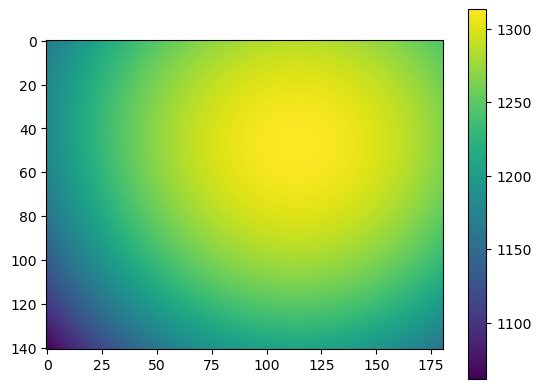

In [216]:
plt.imshow(sf.tisr[21]/3600)
plt.colorbar()

In [260]:
# Path to the NetCDF file
output_file = 'era5_forcing_v2.nc'

# Loop over site IDs (from 2 to 23)
for site_id in range(18, 24):
    # Get the dataset for the current site
    ds = get_forcing_data(site_id)
    
    # Save the dataset to the NetCDF file as a group named "siteXX" (e.g., "site2", "site3", ...)
    ds.to_netcdf(output_file, mode='a', group=f'site{site_id}')

In [236]:
test_ds = xr.open_dataset("era5_forcing.nc", group = "site23")
test_ds

<xarray.Dataset> Size: 147kB
Dimensions:         (valid_time: 120, pressure_level: 37)
Coordinates:
  * valid_time      (valid_time) datetime64[ns] 960B 2008-07-01 ... 2008-07-0...
  * pressure_level  (pressure_level) float64 296B 1e+03 975.0 950.0 ... 2.0 1.0
    latitude        float64 8B ...
    longitude       float64 8B ...
    number          int64 8B ...
    expver          (valid_time) <U4 2kB ...
    lon             float32 4B ...
    lat             float32 4B ...
    site            int32 4B ...
Data variables:
    z               (valid_time, pressure_level) float32 18kB ...
    ta              (valid_time, pressure_level) float32 18kB ...
    rho             (valid_time, pressure_level) float64 36kB ...
    ua              (valid_time, pressure_level) float32 18kB ...
    va              (valid_time, pressure_level) float32 18kB ...
    wa              (valid_time, pressure_level) float32 18kB ...
    hus             (valid_time, pressure_level) float32 18kB ...
    coszen          float32 4B ...
    hfls            (valid_time) float32 480B ...
    hfss            (valid_time) float32 480B ...
    tisr            (valid_time) float32 480B ...
    ts              (valid_time) float32 480B ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-10-05T09:34 GRIB to CDM+CF via cfgrib-0.9.1...

In [123]:
# group the data
group = 17
loc = geo.where(geo["site"] == group, drop = True)
site17sf = sf.where((sf.latitude == loc.lat.values[0]) & (sf.longitude == loc.lon.values[0] - 360), drop = True)
site17col = col.where((col.latitude == loc.lat.values[0]) & (col.longitude == loc.lon.values[0] - 360), drop = True)

In [58]:
loc

NameError: name 'loc' is not defined

In [ ]:
R_d = 287.05  # Specific gas constant for dry air (J/(kg·K))
g = 9.81  # Gravitational acceleration (m/s²)

# Convert pressure from hPa to Pa (1 hPa = 100 Pa)
pressure = col.pressure_level * 100  # Convert to Pa
pressure_broadcasted = pressure.broadcast_like(col.t)
# Compute air density using the ideal gas law: rho = P / (R_d * T)
rho = pressure_broadcasted / (R_d * col.t)

# Add the computed density to the dataset
col['rho'] = rho

In [199]:
# ta, ua, va, hus, alpha/rho, - initial profiles 
# ts, hfls, hfss, coszen, rsdt
col[['z', 't', 'rho', 'u', 'v', 'q']]

ts = site17sf["t2m"] + 2 * (9.8/1000) # approximate surface temperature with dry lapse rate
sf[["slhf", "sshf", "tisr"]]
col["coszen"] = hadgem.coszen

forcing_data = xr.merge([col[["z", "t", "rho", "u", "v", "q", "coszen"]], sf[["slhf", "sshf", "tisr"]]])




<xarray.Dataset> Size: 3GB
Dimensions:         (valid_time: 120, pressure_level: 37, latitude: 141,
                     longitude: 181)
Coordinates:
    number          int64 8B 0
  * valid_time      (valid_time) datetime64[ns] 960B 2008-07-01 ... 2008-07-0...
  * pressure_level  (pressure_level) float64 296B 1e+03 975.0 950.0 ... 2.0 1.0
  * latitude        (latitude) float64 1kB 35.0 34.75 34.5 ... 0.5 0.25 0.0
  * longitude       (longitude) float64 1kB -155.0 -154.8 ... -110.2 -110.0
    expver          (valid_time) <U4 2kB '0001' '0001' '0001' ... '0001' '0001'
    lon             float32 4B 211.0
    lat             float32 4B ...
    site            int32 4B ...
Data variables:
    z               (valid_time, pressure_level, latitude, longitude) float32 453MB ...
    t               (valid_time, pressure_level, latitude, longitude) float32 453MB ...
    rho             (valid_time, pressure_level, latitude, longitude) float64 907MB ...
    u               (valid_time, pressure_level, latitude, longitude) float32 453MB ...
    v               (valid_time, pressure_level, latitude, longitude) float32 453MB ...
    q               (valid_time, pressure_level, latitude, longitude) float32 453MB ...
    coszen          float32 4B 0.7812
    slhf            (valid_time, latitude, longitude) float32 12MB ...
    sshf            (valid_time, latitude, longitude) float32 12MB ...
    tisr            (valid_time, latitude, longitude) float32 12MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-10-05T09:34 GRIB to CDM+CF via cfgrib-0.9.1...

In [237]:
hadgem

<xarray.Dataset> Size: 2MB
Dimensions:    (lev: 38, time: 600)
Coordinates:
    lon        float32 4B 211.0
    lat        float32 4B ...
    site       int32 4B ...
  * lev        (lev) float64 304B 20.0 80.0 180.0 ... 3.291e+04 3.925e+04
  * time       (time) object 5kB 2004-07-01 00:00:00 ... 2008-07-30 18:00:00
Data variables: (12/40)
    zg         (time, lev) float32 91kB ...
    ta         (time, lev) float32 91kB 296.8 296.2 295.2 ... 227.9 232.2 264.3
    hus        (time, lev) float32 91kB ...
    ua         (time, lev) float32 91kB ...
    va         (time, lev) float32 91kB ...
    wap        (time, lev) float32 91kB ...
    ...         ...
    gustiness  float32 4B ...
    windstd    float32 4B ...
    windrms    float32 4B ...
    clwvi      (time) float32 2kB ...
    clivi      (time) float32 2kB ...
    lwp3000    (time) float32 2kB ...

In [132]:
site17col[["t", "q", "u", "v"]]

<xarray.Dataset> Size: 74kB
Dimensions:         (valid_time: 120, pressure_level: 37, latitude: 1,
                     longitude: 1)
Coordinates:
    number          int64 8B 0
  * valid_time      (valid_time) datetime64[ns] 960B 2008-07-01 ... 2008-07-0...
  * pressure_level  (pressure_level) float64 296B 1e+03 975.0 950.0 ... 2.0 1.0
  * latitude        (latitude) float64 8B 35.0
  * longitude       (longitude) float64 8B -125.0
    expver          (valid_time) <U4 2kB ...
Data variables:
    t               (valid_time, pressure_level, latitude, longitude) float32 18kB ...
    q               (valid_time, pressure_level, latitude, longitude) float32 18kB ...
    u               (valid_time, pressure_level, latitude, longitude) float32 18kB ...
    v               (valid_time, pressure_level, latitude, longitude) float32 18kB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-10-05T09:34 GRIB to CDM+CF via cfgrib-0.9.1...

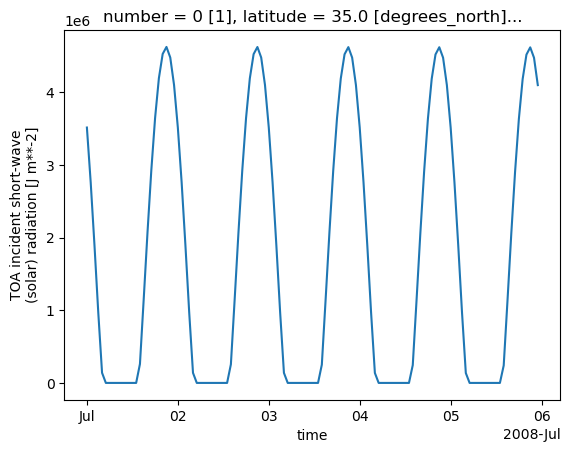

In [95]:
site17data["tisr"].plot()

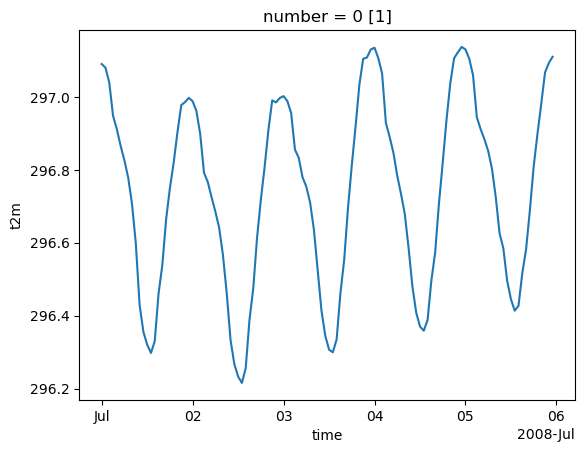

In [97]:
sf.mean(dim = ["latitude", "longitude"])["t2m"].plot()

In [5]:
# now lets do this in temperature uni

# lets get the data in hadgem form 
hadgem = xr.open_dataset("/Users/julianschmitt/Downloads/HadGEM2-A_amip.2004-2008.07.nc", group = "site23")

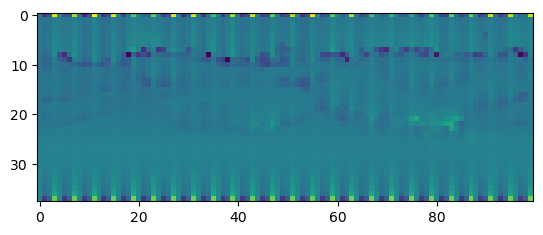

In [12]:
# ta, ua, va, hus, alpha/rho, - initial profiles 
# ts, hfls, hfss, coszen, rsdt
plt.imshow(np.transpose(hadgem.tntr.values[:100, :]))

In [148]:
1/ hadgem.alpha.values[0, :]

array([1.1791223 , 1.1735959 , 1.1641325 , 1.1508752 , 1.1339201 ,
       1.1131504 , 1.0848188 , 1.0548562 , 1.0210884 , 0.9830358 ,
       0.9223374 , 0.88197744, 0.836112  , 0.7931723 , 0.7482449 ,
       0.70319986, 0.6556908 , 0.6106781 , 0.5688524 , 0.5223333 ,
       0.47889155, 0.43583542, 0.3916802 , 0.34959084, 0.31037554,
       0.27361238, 0.23867404, 0.20519851, 0.16413954, 0.13068715,
       0.10224383, 0.07876343, 0.05908536, 0.04374693, 0.03101151,
       0.02049693, 0.01168244, 0.00408555], dtype=float32)

In [153]:
col.z.values[0, :, 0, 0]

array([  1676.1484,   3788.7427,   5940.244 ,   8132.7617,  10368.523 ,
        12652.445 ,  15011.297 ,  17445.86  ,  19950.809 ,  22533.078 ,
        25200.027 ,  30788.105 ,  36737.285 ,  43113.73  ,  49994.168 ,
        57410.38  ,  65444.477 ,  74220.06  ,  83867.69  ,  94621.5   ,
       106856.31  , 113691.69  , 121129.44  , 129327.375 , 138553.88  ,
       149342.69  , 162500.38  , 183798.25  , 204391.44  , 236328.    ,
       262363.2   , 308149.75  , 332347.88  , 355682.5   , 392348.    ,
       422554.8   , 475291.3   ], dtype=float32)

In [161]:
col.pressure_level

<xarray.DataArray 'pressure_level' (pressure_level: 37)> Size: 296B
array([1000.,  975.,  950.,  925.,  900.,  875.,  850.,  825.,  800.,  775.,
        750.,  700.,  650.,  600.,  550.,  500.,  450.,  400.,  350.,  300.,
        250.,  225.,  200.,  175.,  150.,  125.,  100.,   70.,   50.,   30.,
         20.,   10.,    7.,    5.,    3.,    2.,    1.])
Coordinates:
    number          int64 8B ...
  * pressure_level  (pressure_level) float64 296B 1e+03 975.0 950.0 ... 2.0 1.0
Attributes:
    long_name:         pressure
    units:             hPa
    positive:          down
    stored_direction:  decreasing
    standard_name:     air_pressure

In [177]:
R_d = 287.05  # Specific gas constant for dry air (J/(kg·K))
g = 9.81  # Gravitational acceleration (m/s²)

# Assuming your dataset `col` contains:
# - 'z' for geopotential height (m²/s²) 
# - 't' for temperature (K)
# - 'pressure_levels' as the index in hPa

# Convert pressure from hPa to Pa (1 hPa = 100 Pa)
pressure = col.pressure_level * 100  # Convert to Pa
pressure_broadcasted = pressure.broadcast_like(col.t)
# Compute air density using the ideal gas law: rho = P / (R_d * T)
rho = pressure_broadcasted / (R_d * col.t)

# Add the computed density to the dataset
col['rho'] = rho

# If you need specific volume (alpha = 1/rho), you can compute it as well
alpha = 1 / rho
col['alpha'] = alpha

# Optionally, save the modified dataset with the new variables
# col.to_netcdf('updated_col_with_density.nc')

# Access the new density and specific volume variables
print(col['rho'])
print(col['alpha'])

<xarray.DataArray 'rho' (valid_time: 120, pressure_level: 37, latitude: 141,
                         longitude: 181)> Size: 907MB
array([[[[1.19989163, 1.19973834, 1.19958498, ..., 1.10875347,
          1.10886383, 1.10929137],
         [1.19905279, 1.19898023, 1.19888354, ..., 1.10909135,
          1.1098988 , 1.10896029],
         [1.19819896, 1.19822307, 1.19809432, ..., 1.11774432,
          1.10983663, 1.10836771],
         ...,
         [1.16912434, 1.16901714, 1.16871069, ..., 1.17419634,
          1.17455201, 1.17481505],
         [1.16910907, 1.16887153, 1.16838148, ..., 1.17442053,
          1.17469893, 1.17494661],
         [1.16884089, 1.16845806, 1.16792253, ..., 1.17454425,
          1.17476858, 1.17495438]],

        [[1.17840827, 1.17831248, 1.17812894, ..., 1.08601679,
          1.08645784, 1.08706218],
         [1.17760234, 1.17758645, 1.17741103, ..., 1.08645784,
          1.087069  , 1.08664789],
         [1.1767498 , 1.17676567, 1.17665416, ..., 1.09481588,
      

In [178]:
col['rho'].values[0, :, 0, 0]

array([1.19989163, 1.17840827, 1.15669872, 1.13478712, 1.11171286,
       1.08479956, 1.04274237, 1.01586031, 0.98531648, 0.95392348,
       0.92408916, 0.86876803, 0.81559104, 0.75624873, 0.70114424,
       0.64928826, 0.59638331, 0.54442306, 0.49273025, 0.43777551,
       0.38052954, 0.35126691, 0.32118785, 0.28892483, 0.25285229,
       0.21142828, 0.16981081, 0.11565359, 0.08122318, 0.04731698,
       0.03077763, 0.0149361 , 0.01018966, 0.00712965, 0.00408932,
       0.00265266, 0.00131135])

In [ ]:
tntva_trend = []
# for bottom level 
bottom = center.w[:, 0] * (center.t[:, 1] - center.t[:, 0]) / (center.z[:, 1] - center.z[:, 0])

# for middle levels we'll use centered finite differences
i= 1
level = center.w[:, i] * (center.t[:, i+1] - 2 * center.t[:, i] +  center.t[:, i-1]) / ((center.z[:, i+1] - center.z[:, i-1]))

# tnhusha = center.u * (west.q - 2 * center.q + east.q) / (2 * dx / 4) + center.v * (south.q - 2 * center.q + north.q) / (2 * dy / 4)


# for top level
center.w[:, 36] * (center.t[:, 36] - center.t[:, 35]) / (center.z[:, 36] - center.z[:, 35])